In [13]:
import os
import json
import pdfplumber
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pickle

In [83]:
# Step 3: Load documents from saved json file and Chunk documents
with open(OUTPUT_JSON, "r", encoding="utf-8") as f:
    documents = json.load(f)
    
def chunk_text(text, chunk_size=1000, overlap=200):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i+chunk_size])
        chunks.append(chunk)
    return chunks

doc_chunks = {}
for doc_name, text in documents.items():
    doc_chunks[doc_name] = chunk_text(text)


In [84]:
# Step 4: Generate embeddings for all chunks
model = SentenceTransformer("all-mpnet-base-v2")

all_chunks = []
chunk_map = []  # Keep track of which chunk belongs to which doc
for doc_name, chunks in doc_chunks.items():
    all_chunks.extend(chunks)
    chunk_map.extend([doc_name] * len(chunks))

print(f"Total chunks to embed: {len(all_chunks)}")
embeddings_chunks = model.encode(all_chunks, show_progress_bar=True)


Total chunks to embed: 7454


Batches:   0%|          | 0/233 [00:00<?, ?it/s]

In [85]:
# Step 5: Aggregate embeddings per document (mean of chunks)
doc_embeddings = {}
for doc_name in doc_chunks.keys():
    indices = [i for i, d in enumerate(chunk_map) if d == doc_name]
    doc_embeddings[doc_name] = np.mean(embeddings_chunks[indices], axis=0)

In [86]:
# Step 5: Save aggregated embeddings and doc names
EMBEDDINGS_FILE = "doc_embeddings.npy"
DOCNAMES_FILE = "doc_names.pkl"

np.save(EMBEDDINGS_FILE, np.array(list(doc_embeddings.values())))
with open(DOCNAMES_FILE, "wb") as f:
    pickle.dump(list(doc_embeddings.keys()), f)


In [87]:
# Step 6: Load embeddings for nearest neighbor search fromn persisted files
embeddings = np.load(EMBEDDINGS_FILE)
with open(DOCNAMES_FILE, "rb") as f:
    doc_names = pickle.load(f)

In [88]:
# Step 10: Nearest Neighbor Search
nn = NearestNeighbors(n_neighbors=11, metric="cosine")
nn.fit(embeddings)

NearestNeighbors(metric='cosine', n_neighbors=11)

In [89]:
def find_similar(doc_index, top_k=10):
    distances, indices = nn.kneighbors([embeddings[doc_index]], n_neighbors=top_k+1)
    print(f"\nTop {top_k} similar to: {doc_names[doc_index]}")
    for rank, (i, dist) in enumerate(zip(indices[0][1:], distances[0][1:]), start=1):
        print(f"{rank}. {doc_names[i]} (similarity = {1 - dist:.3f})")

# Example: find top-10 similar to the first constitution
# find_similar(0, top_k=10)
find_similar(doc_names.index('Nepal_2016.pdf'), top_k=10)


Top 10 similar to: Nepal_2016.pdf
1. Bhutan_2008.pdf (similarity = 0.828)
2. Thailand_2017.pdf (similarity = 0.816)
3. Bangladesh_2014.pdf (similarity = 0.815)
4. India_2016.pdf (similarity = 0.814)
5. Swaziland_2005.pdf (similarity = 0.808)
6. Afghanistan_2004.pdf (similarity = 0.800)
7. Pakistan_2018.pdf (similarity = 0.800)
8. Cambodia_2008.pdf (similarity = 0.774)
9. Myanmar_2015.pdf (similarity = 0.773)
10. Kenya_2010.pdf (similarity = 0.767)


In [82]:
find_similar(doc_names.index('United_Kingdom_2013.pdf'), top_k=10)


Top 10 similar to: United_Kingdom_2013.pdf
1. New_Zealand_2014.pdf (similarity = 0.800)
2. Ireland_2019.pdf (similarity = 0.773)
3. St_Vincent_and_the_Grenadines_1979.pdf (similarity = 0.771)
4. Antigua_and_Barbuda_1981.pdf (similarity = 0.770)
5. Swaziland_2005.pdf (similarity = 0.749)
6. St_Lucia_1978.pdf (similarity = 0.748)
7. Barbados_2007.pdf (similarity = 0.732)
8. Tuvalu_2010.pdf (similarity = 0.731)
9. Solomon_Islands_2018.pdf (similarity = 0.730)
10. Sri_Lanka_2015.pdf (similarity = 0.727)


In [76]:
find_similar(doc_names.index('United_States_of_America_1992.pdf'), top_k=10)


Top 10 similar to: United_States_of_America_1992.pdf
1. Liberia_1986.pdf (similarity = 0.684)
2. Mexico_2015.pdf (similarity = 0.676)
3. Philippines_1987.pdf (similarity = 0.675)
4. Argentina_1994.pdf (similarity = 0.674)
5. Palau_1992.pdf (similarity = 0.672)
6. Micronesia_1990.pdf (similarity = 0.660)
7. Lebanon_2004.pdf (similarity = 0.657)
8. France_2008.pdf (similarity = 0.642)
9. Afghanistan_2004.pdf (similarity = 0.642)
10. Ireland_2019.pdf (similarity = 0.641)


In [73]:
char_counts = {key: len(value) for key, value in documents.items()}
sorted_counts = sorted(char_counts.items(), key=lambda x: x[1])

# Step 11: Get top 10 lowest and highest
lowest_10 = sorted_counts[:20]
highest_10 = sorted_counts[-20:]  # last 10 items

print("Lowest 10 counts:")
for k, v in lowest_10:
    print(k, v)

print("\nHighest 10 counts:")
for k, v in reversed(highest_10):  # reverse to get descending order
    print(k, v)

Lowest 10 counts:
St_Kitts_and_Nevis_1983.pdf 20697
Libya_2012.pdf 35905
Papua_New_Guinea_2016.pdf 39520
Monaco_2002.pdf 49448
Iceland_2013.pdf 50733
Bosnia_Herzegovina_2009.pdf 52864
Denmark_1953.pdf 54283
Lebanon_2004.pdf 54885
Micronesia_1990.pdf 57397
Japan_1946.pdf 57669
Saudi_Arabia_2013.pdf 61987
Latvia_2016.pdf 62249
Indonesia_2002.pdf 62399
United_States_of_America_1992.pdf 65052
Eritrea_1997.pdf 65431
Comoros_2018.pdf 65713
Qatar_2003.pdf 65753
Djibouti_2010.pdf 66336
Chile_2023D.pdf 66370
Luxembourg_2009.pdf 66585

Highest 10 counts:
United_Kingdom_2013.pdf 2084088
New_Zealand_2014.pdf 1179380
India_2016.pdf 685164
Brazil_2017.pdf 529413
Mexico_2015.pdf 456016
Sri_Lanka_2015.pdf 444506
Malaysia_2007.pdf 443072
Nigeria_2011.pdf 441031
Ecuador_2021.pdf 427333
Gambia_2020D.pdf 421134
Zimbabwe_2017.pdf 402986
Chile_2022D.pdf 401534
Colombia_2015.pdf 398657
Gambia_2019D.pdf 396909
Nepal_2016.pdf 396786
Sweden_2012.pdf 394452
Pakistan_2018.pdf 392951
Ghana_1996.pdf 377188
Chile_20

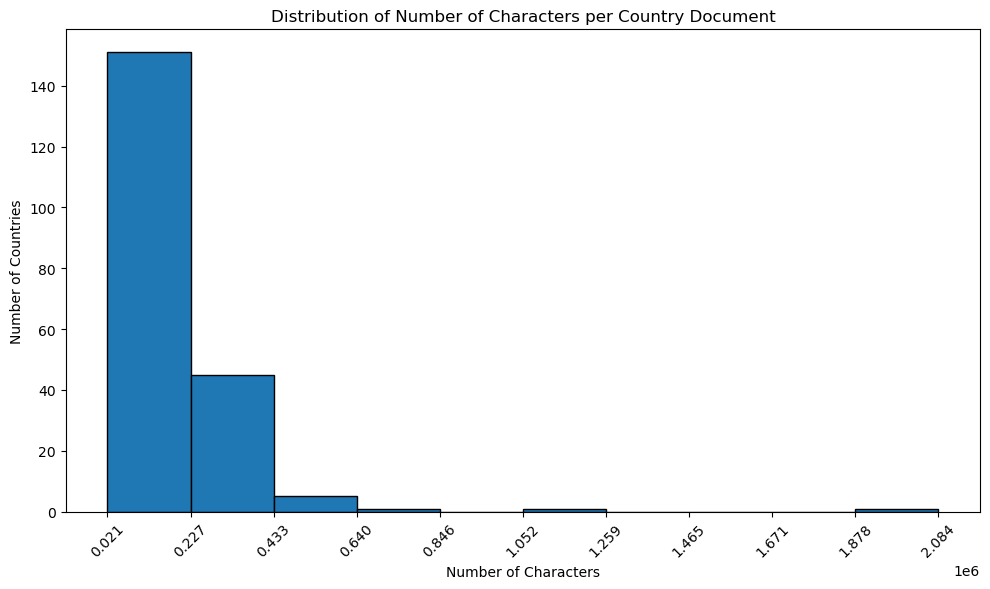

In [74]:
counts = list(char_counts.values())

# Step 12: Plot for step 11
min_count = min(counts)
max_count = max(counts)
bins = np.linspace(min_count, max_count, 11)  # 10 bins

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(counts, bins=bins, edgecolor='black')

plt.xlabel("Number of Characters")
plt.ylabel("Number of Countries")
plt.title("Distribution of Number of Characters per Country Document")
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()